# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
import math


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        if line is not None:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def print_image(img,title=None):
    plt.figure()
    if title is not None:
        plt.title(title)
    plt.imshow(img,cmap='gray')

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
import os
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [4]:
def point_slope(x1,y1,x2,y2):
    m = (y2-y1)/(x2-x1)
    b = y1 - m * x1
    return m,b

In [5]:
print(point_slope(1,0,2,1))

(1.0, -1.0)


In [6]:
def polar_from_segment(x1,y1,x2,y2):
    theta = math.atan2(y2-y1,x2-x1)
    if x1==x2:
        r =x1
    else:
        m,b = point_slope(x1,y1,x2,y2)
        if m==0:
            r = y1
        else:
            A=m
            B=-1
            C=b
            r = abs(C)/math.sqrt(A*A+B*B)
    return r,theta

In [7]:
polar_from_segment(1,0,2,1)

(0.7071067811865475, 0.7853981633974483)

In [8]:
def lane_line_from_lines(lines, clip):
    min_y = 99999
    max_y = 0
    for x,y in clip:
        if y < min_y:
            min_y = y
        if y > max_y:
            max_y = y
    # fit all the points to a single line
    all_x = []
    all_y = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            all_x.append(x1)
            all_y.append(y1)
            all_x.append(x2)
            all_y.append(y2)
    if(len(lines)==0):
        return None
    p = np.polyfit(all_y,all_x,1)
    x_at_min = np.polyval(p,min_y)
    x_at_max = np.polyval(p,max_y)
    line = (x_at_min,min_y,x_at_max,max_y)
    #print(line)
    return line
    
            
        
        

In [9]:
def process_image(image, debug=False):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    gray = grayscale(image)
    if(debug):
        plt.figure()
        plt.title('gray')
        plt.imshow(gray, cmap='gray')
    
    blurred = gaussian_blur(gray,3)
    if(debug):
        plt.figure()
        plt.title('blurred')
        plt.imshow(blurred, cmap='gray')
    
    cannied = canny(blurred,low_threshold=30,high_threshold=100)
    if(debug):
        plt.figure()
        plt.title('canny')
        plt.imshow(cannied, cmap='gray')
    
    
    h,w,_=image.shape
    lborder = 100
    rborder = 30
    top = 320
    gap = 30
    bottom = h
    poly = [(lborder,bottom-1),(w/2-gap,top),(w/2+gap,top),(w-rborder,bottom-1)]
    #print(poly)
    interesting = region_of_interest(cannied, np.int32([poly]))

    #todo: only have one hough
    lines = cv2.HoughLinesP(interesting, rho = 3, theta = 2 * math.pi/180., threshold=5, minLineLength=30, maxLineGap=10)
    houghed = interesting.copy()
    draw_lines(houghed, lines)

    #houghed = hough_lines(interesting, rho = 3, theta = 2 * math.pi/180., threshold =5, min_line_len=30, max_line_gap=10)
    if(debug):
        plt.figure()
        plt.title('houghed')
        plt.imshow(houghed, cmap='gray')
    if debug:
        cv2.polylines(image, np.int32([poly]), True, (0,0,255),3)
    
    left_lines = []
    right_lines = []
    rejected_lines = []
    
    # find left and right lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            if(x2<x1):
                x2,x1 = x1,x2
                y2,y1 = y1,y2
            slope = math.atan2(-(y2-y1),x2-x1)*180./math.pi
            if slope > 25 and slope < 50:
                left_lines.append([(x1,y1,x2,y2)])
                if debug: print("left slope :{}".format(slope))
            elif slope > -50 and slope < -25:
                right_lines.append([(x1,y1,x2,y2)])
                if debug: print("right slope :{}".format(slope))
            else:
                rejected_lines.append([(x1,y1,x2,y2)])
                if debug: print("rejected slope :{}".format(slope))
    if debug:
        draw_lines(image, left_lines, [255,0,0])
        draw_lines(image, right_lines, [0,255,0])
        draw_lines(image, rejected_lines, [0,0,0])
    
    
    # find and draw single left and right line
    for lane_lines in [left_lines,right_lines]:
        single_line = lane_line_from_lines(lane_lines,poly)
        if single_line is not None:
            draw_lines(image,[[single_line]],(0,0,255),thickness=4)
    return image


processing test_images/solidYellowCurve2.jpg
processing test_images/solidWhiteRight.jpg
processing test_images/whiteCarLaneSwitch.jpg
processing test_images/solidYellowCurve.jpg
processing test_images/solidWhiteCurve.jpg
processing test_images/solidYellowLeft.jpg


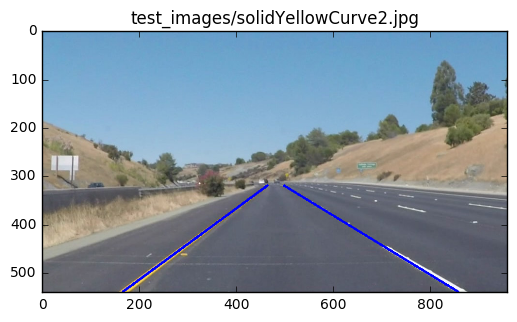

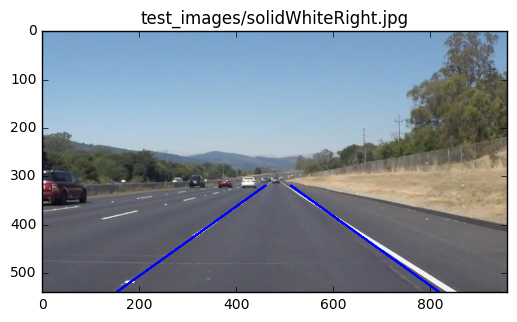

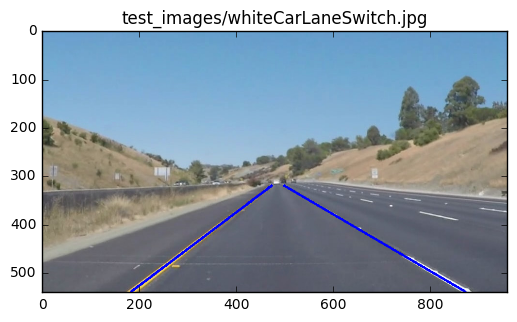

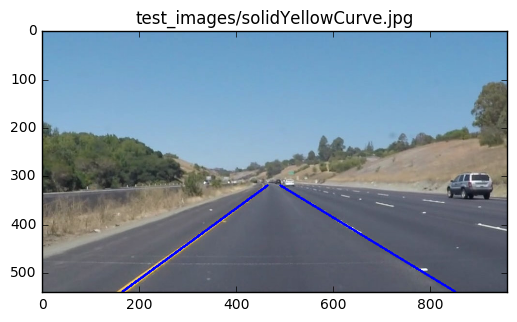

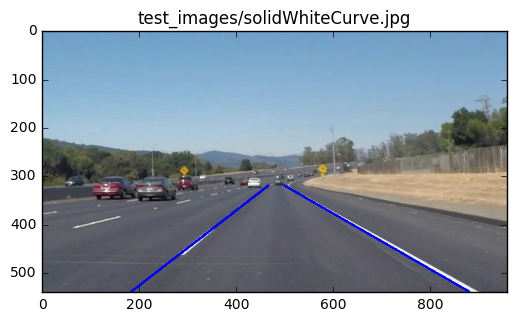

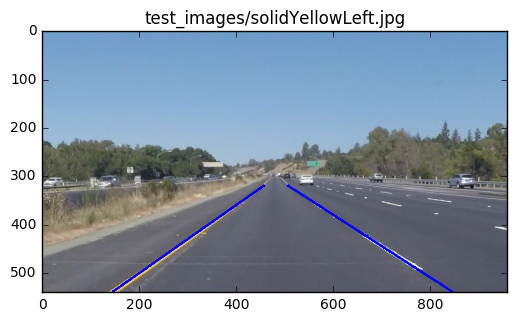

In [10]:
folder = "test_images"
for file_name in os.listdir(folder):
    file_path = "/".join([folder , file_name])
    print("processing {}".format(file_path))
    #reading in an image
    image = mpimg.imread(file_path)
    #printing out some stats and plotting
    #print('This image is:', type(image), 'with dimesions:', image.shape)
    #plt.figure()
    #plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    processed = process_image(image, debug=False)
    plt.figure()
    plt.title(file_path)
    plt.imshow(processed)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [12]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:14<00:00, 11.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 6s, sys: 3.79 s, total: 1min 10s
Wall time: 15.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:51<00:00, 13.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 3min 48s, sys: 13.1 s, total: 4min 1s
Wall time: 52.5 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Making the Pipeline More Robust

There are several issues and areas for improvement I see in the simple pipeline implementation above.

### Issues with Current Implementation

#### Lane Lines have Two Edges
First, we are using the edges of the lane marker to find lines.  In a perfect image, we would get two lines, one on the left side of the lane line and one on the right edge of the lane line.  Sometimes we only get a line on one side or the other.  

Recommendation: Our code should look specifically for two edges per lane line, one on the left, one on the right.  It could then fit the lines individually and find the line between these two lane lines. 


#### We Ignore Previous Frames
Our pipeline ignores previous frames.  If we know where the lane line is in one frame, we can be pretty certain that it will move only slightly between frames.  

Recommendation: Remember lane position from the previous frame and use this to create a much tighter region of interest and line filter.

#### Bad Line Matches Carry Too Much Weight 
When we find a line segment that isn't actually part of the lane marker, our least squares minimization fit causes a huge error in the fit.

Recommendation: Apply ransac to the fitting process

#### Pipeline Parameters Hard Coded
The pipeline has things like region of interest that will vary between cars with different camera orientations and focal lengths. 

Recommendation: Parameterize variables that change based on car and camera placement including the region of interest. Ideally these could be "learned" by the program, but at least allow them to be specified.

#### Sensitive to Lighting Conditions
The line detection is sensitive to lighting conditions.  Shadows and different road and marker colorings affect the algorithm.

Recommendation:  Play with different color spaces like HSV and YUV to see which are better at making lanes stand out.  Also, can use histogram equalization of the original image or even the gradient image to help even out changes in lighting and road surface.


### Planned Fixes

#### Parameterized Detector
Roll the detection logic into a Python class so it is easier to pass tweaks to the detection algorithm. It also lets us avoid the global variables we will need when we compare frames.

#### Oriented Gradient Filter
Use an oriented gradient to find the left and right edges of the lines.  For example, a do a soble filter in the x and y direction and then use the atan2 function to find the orientation of the gradient. We can then filter for specific edges before feeding to our Hough detecter.  For example, to find the left edge of the left line, we filter to pixels with a gradient in the downward right direction.

Do a orientation gradient calculation (sobel_x , soble_y, arctan...), maybe scharrr
	phase(InputArray x, InputArray y, OutputArray angle, bool angleInDegrees=false)
For the left, select only positive slopes near the expected slope, this is the right side of the left lane line
Can use the opposite slope for the left side of the lane line
For the right, select only negative slopes near the expected slope, this is the left side of the line
Find the median rho and theta for each side of lane line
Feed the four different results into a canny detector for each edge of each line

#### Lock onto Detected Region

If we found a line edge in the previous frame, the new line can't be far away.  Use a distance from line filter to only keep points that are likely to contain the edge we want.


#### Ransac Line Detector

There will still be noise after all the filtering, we want points on the line to take precidence. A Ransac line detector can reject noise better than a least squares fit.

#### Yellow / White detection?
Use a color model that is more sensitive to changes to yellow or white lines from the road.  Hopefully this can help detection in the light colored section of the road.

#### Average the left / right edges if you actually found both edges
Since we are being more selective on our gradients by adding slope, we can probably accept lower thresholds for the gradient slope.  This can get complicated if only one line or the other appears. Alternatively, only look for the inside edge of the line since this is far less complicated.



## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [16]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:32<00:00,  8.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 2min 17s, sys: 8.14 s, total: 2min 25s
Wall time: 33.9 s


### Challenge Code

In [17]:
# see http://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html

from sklearn import linear_model, datasets
def ransac_fit(x,y):
    #print("x: {}".format(x))
    #print("y: {}".format(y))
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),residual_threshold=5)
    model_ransac.fit(x, y)
    return model_ransac

def ransac_image(img,predict_x=True):
    x,y = np.nonzero(img)
    x = x.reshape(len(x),1)
    y = y.reshape(len(y),1)
    #print(x)
    #print(y)
    try:
        if predict_x:
            model=ransac_fit(y,x)
        else:
            model=ransac_fit(x,y)
    except:
        model = None
    #print("ransac coef:{} intercept:{}".format(model.estimator_.coef_, model.estimator_.intercept_))
    return model
    


In [18]:
x = np.arange(50).reshape(50,1)
y = 3.*np.arange(50).reshape(50,1)
y[5] = 999
model = ransac_fit(x,y)
model.get_params()
model.estimator_.coef_

array([[ 3.]])

In [19]:

def oriented_gradient(img,ksize=5, debug=False, deg=0):
    sobelx = cv2.Sobel(img,cv2.CV_32F,dx=1,dy=0,ksize=ksize)
    sobely = cv2.Sobel(img,cv2.CV_32F,dx=0,dy=1,ksize=ksize)
    oriented = sobelx + (1.0j * sobely)
    direction = np.angle(oriented,deg=deg)
    magnitude = np.abs(oriented)


    if debug:
        plt.figure()
        plt.title('sobelx')
        plt.imshow(sobelx, cmap='gray')
        plt.figure()
        plt.title('sobely')
        plt.imshow(sobely, cmap='gray')
    
    if debug:
        plt.figure()
        plt.title('direction')
        plt.imshow(direction,cmap='gray')
    
    if debug:
        plt.figure()
        plt.title('magnitude')
        plt.imshow(magnitude,cmap='gray')
    return magnitude,direction


def gradient_for_angles(magnitude,direction,theta,tolerance):
    filter = np.logical_and(direction > theta-tolerance,direction < theta+tolerance)
    gradient = np.multiply(filter,magnitude)
    return gradient
        
def im_float_to_int(img):
    low = np.min(img)
    high = np.max(img)
    out = np.uint8((np.subtract(img,low)/(high-low))*255.)
    return out

def im_int_to_binary(img, threshold = None):
    if threshold is None:
        threshold=np.mean(img)
    th, dst = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    
    return dst

def show_gradient_for_angles(magnitude,direction,theta,tolerance):
    matched = gradient_for_angles(magnitude,direction,theta,tolerance)

    plt.figure()
    plt.title('matched: {} tolerance {}, max={}'.format(theta,tolerance,np.max(matched)))
    imint = im_float_to_int(matched)
    plt.imshow(imint,cmap='gray')



In [20]:
def process_challenge_image(img, show_hough = False, clip_region = None, draw_clip_region = False, use_hough=False, use_ransac=True):
    #img = mpimg.imread("test_images/solidYellowCurve.jpg")
    gray = grayscale(img)
    mag,direction = oriented_gradient(gray,deg=1)
    #print_image(mag,'mag')
    #print_image(direction,'direction')
    red = (255,0,0)
    green = (0,255,0)
    blue = (0,0,255)
    cyan = (0,255,255)
    white = (255,255,255)
    for theta,color in [(60,red),(-125,green),(-60,blue),(120,cyan)]: # lane detectors ordered from left to right
        imfloat = gradient_for_angles(mag,direction,theta,15)
        #print_image(imfloat, "imfloat")
        imint = im_float_to_int(imfloat)
        #print_image(imint, "imint")
        imbinary = im_int_to_binary(imint,20)
        if clip_region is not None:
            imbinary = region_of_interest(imbinary,np.int32([clip_region]))
        if draw_clip_region:
            cv2.polylines(img, np.int32([clip_region]), isClosed=True, color=white, thickness=3)
        #print_image(imbinary,"imbinary")
        #show_gradient_for_angles(mag,direction, theta,15)
        if use_hough:
            lines = cv2.HoughLinesP(imbinary, rho = 3, theta = 2 * math.pi/180., threshold=20, minLineLength=20, maxLineGap=3)
            if lines is not None:
                if show_hough:
                    draw_lines(img,lines,color)
                single_line = lane_line_from_lines(lines,clip_region)
                if single_line is not None:
                    draw_lines(img,[[single_line]],color,thickness=4)
                
        #do ransac prediction
        if use_ransac:
            model = ransac_image(imbinary, predict_x=False)
            if model is not None:
                min_y = 99999
                max_y = 0
                for x,y in clip_region:
                    if y < min_y:
                        min_y = y
                    if y > max_y:
                        max_y = y
                min_x = model.predict(min_y)
                max_x = model.predict(max_y)
                draw_lines(img,[[(min_x, min_y, max_x, max_y)]], color, thickness=4)
        #print_image(imbinary,'imbinary')

    return img

In [21]:
class challenge_processor:
    def __init__(self):
        self.show_hough = False
        self.clip_region =  [(175,700),(1200,700),(800,450),(575,450)]
        self.draw_clip_region = False
    
    def process_image(self, img):
        return process_challenge_image(img,show_hough = self.show_hough, clip_region = self.clip_region, draw_clip_region = self.draw_clip_region)

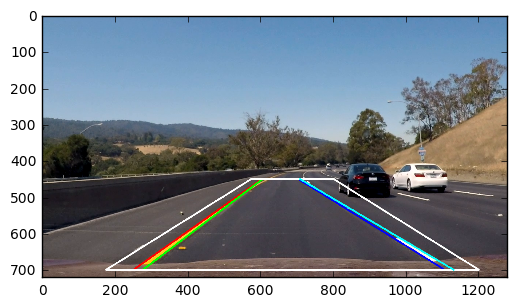

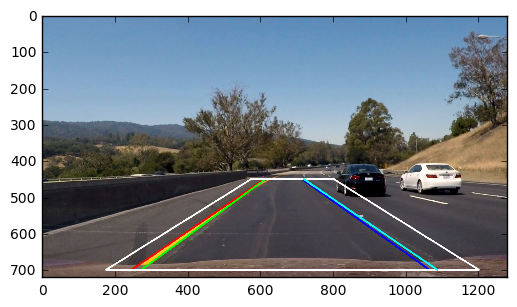

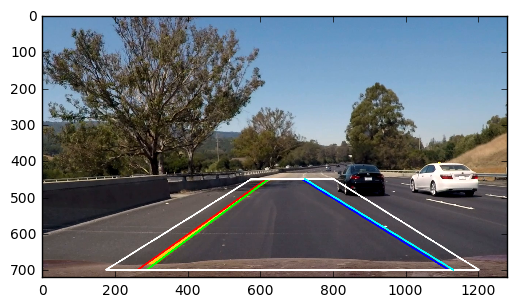

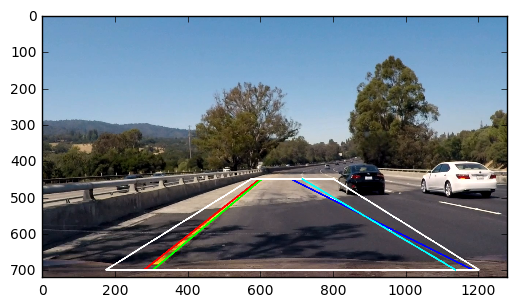

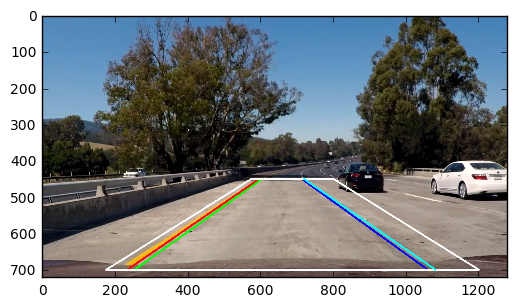

In [22]:
processor = challenge_processor()
processor.show_hough = False
processor.draw_clip_region = True
clip = VideoFileClip('challenge.mp4')
print_image(processor.process_image(clip.get_frame(1)))
print_image(processor.process_image(clip.get_frame(2)))
print_image(processor.process_image(clip.get_frame(3)))
print_image(processor.process_image(clip.get_frame(4)))
print_image(processor.process_image(clip.get_frame(5)))
    

In [23]:
processor = challenge_processor()
processor.show_hough = False
processor.draw_clip_region = False
challenge_lines_output = 'challenge_lines.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_lines_clip = clip2.fl_image(processor.process_image)
%time challenge_lines_clip.write_videofile(challenge_lines_output , audio=False)
                   

[MoviePy] >>>> Building video challenge_lines.mp4
[MoviePy] Writing video challenge_lines.mp4


100%|██████████| 251/251 [01:32<00:00,  2.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_lines.mp4 

CPU times: user 7min 58s, sys: 24.8 s, total: 8min 23s
Wall time: 1min 33s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>

""".format(challenge_lines_output))